In [194]:
from sec_api import ExtractorApi
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
import re

cik_lookup = {
    'AMZN': '0001018724',
    'IBM': '0000051143',   
    'BA': '0000012927',
    'DIS': '0001001039',
    'GE': '0000040545'}


def get_sec_data(file):
    text_file = open(file, "r")
    sec_data = text_file.read()
    sec_data_final = ""
    for i in range(0,len(sec_data)):
        if sec_data[i].isascii():
            sec_data_final+=sec_data[i]
    feed = BeautifulSoup(sec_data_final.encode('ascii'), "html.parser")
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=True)]
    return entries

sec_data = {}

for ticker,cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(ticker+"_entries.txt")

raw_fillings_by_ticker = {}

tenK_sections = {'1','1A','1B','2','3','4','5','6','7','7A','8','9','9A','9B','10','11','12','13','14'}
#tenK_sections = {'1','1A'}

extractorApi = ExtractorApi("a53729863debe9bac6c94e256a9c5533f799f78084a57e39aa2e21e6a8b03391")

ten_ks_by_ticker = {}

for ticker,cik in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    ten_ks_by_ticker[ticker] = []
    for index_url, file_type, file_date in tqdm(cik, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url
            raw_fillings_by_ticker[ticker][file_date] = {}
            text = ""
            for section in tenK_sections: 
                text = text + extractorApi.get_section(file_url, section, "text")
                raw_fillings_by_ticker[ticker][file_date][section] = extractorApi.get_section(file_url, section, "text")
            ten_ks_by_ticker[ticker].append({
                    'cik': cik,
                    'file': text,
                    'file_date': file_date})


In [195]:
def clean_text(text):
    text = text.lower()
    
    return text

In [196]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])

def print_ten_k_data(ten_k_data, fields, field_length_limit=50):
    indentation = '  '

    print('[')
    for ten_k in ten_k_data:
        print_statement = '{}{{'.format(indentation)
        for field in fields:
            value = str(ten_k[field])

            # Show return lines in output
            if isinstance(value, str):
                value_str = '\'{}\''.format(value.replace('\n', '\\n'))
            else:
                value_str = str(value)

            # Cut off the string if it gets too long
            if len(value_str) > field_length_limit:
                value_str = value_str[:field_length_limit] + '...'

            print_statement += '\n{}{}: {}'.format(indentation * 2, field, value_str)

        print_statement += '},'
        print(print_statement)
    print(']')
example_ticker = 'AMZN'
print_ten_k_data(ten_ks_by_ticker['AMZN'][:5], ['file_clean'])

Cleaning GE 10-Ks: 100%|██████████| 21/21 [00:00<00:00, 806.5210-K/s]

[
  {
    file_clean: ' item 1b. unresolved staff comments \n\nnone. \n\...},
  {
    file_clean: 'too many requests. item 14. \n\nprincipal account...},
  {
    file_clean: ' item 1b. \n\nunresolved staff comments \n\nnone....},
  {
    file_clean: ' item 1b. \n\nunresolved staff comments \n\nnone....},
  {
    file_clean: ' item 1b. \n\nunresolved staff comments \n\nnone....},
]


In [197]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    
    # TODO: Implement
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    
    return lemmatized_words

word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize GE 10-Ks: 100%|██████████| 21/21 [00:02<00:00,  9.0310-K/s]

[
  {
    file_lemma: '['item', '1b', 'unresolved', 'staff', 'comment', ...},
  {
    file_lemma: '['too', 'many', 'request', 'item', '14', 'princip...},
  {
    file_lemma: '['item', '1b', 'unresolved', 'staff', 'comment', ...},
  {
    file_lemma: '['item', '1b', 'unresolved', 'staff', 'comment', ...},
  {
    file_lemma: '['item', '1b', 'unresolved', 'staff', 'comment', ...},
]


In [198]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for GE 10-Ks: 100%|██████████| 21/21 [00:01<00:00, 18.0610-K/s]

Stop Words Removed


In [199]:
import os


sentiments = ['negative', 'positive', 'uncertainty']

sentiment_df = pd.read_csv('LoughranMcDonald_MasterDictionary_2020.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df = sentiment_df.rename(columns={"negative": "negative_lm","positive":"positive_lm","uncertainty":"uncertainty_lm"})
sentiment_df.head()

,negative_lm,positive_lm,uncertainty_lm,word
9,True,False,False,abandon
12,True,False,False,abandonment
13,True,False,False,abandonments
51,True,False,False,abdicate
54,True,False,False,abdication


In [200]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer


def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def get_sentiment(word,tag):
    """ returns list of pos neg and objective score. But returns empty list if not present in senti wordnet. """

    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

sentiment_df["positive_swn"] = False * len(sentiment_df)
sentiment_df["negative_swn"] = False * len(sentiment_df)
sentiment_df["objective_swn"] = False * len(sentiment_df)
words = sentiment_df['word'].to_numpy()
pos_val = nltk.pos_tag(words)
senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
for i in range(0,len(sentiment_df)):
    scores = senti_val[i]
    if scores != []:
        if scores[0]> 0:
            sentiment_df["positive_swn"][i]= True
        if scores[1]> 0:
            sentiment_df["negative_swn"][i]= True
        if scores[2]> 0:
            sentiment_df["objective_swn"][i]= True
sentiment_df = sentiment_df.replace(0,False)
sentiment_df.head()

<ipython-input-200-d45eb5dd6fc8>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["objective_swn"][i]= True
<ipython-input-200-d45eb5dd6fc8>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["positive_swn"][i]= True
<ipython-input-200-d45eb5dd6fc8>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df["negative_swn"][i]= True
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: Settin

,negative_lm,positive_lm,uncertainty_lm,word,positive_swn,negative_swn,objective_swn
9,True,False,False,abandon,True,False,True
12,True,False,False,abandonment,False,False,True
13,True,False,False,abandonments,True,False,True
51,True,False,False,abdicate,True,False,True
54,True,False,False,abdication,False,False,True


In [201]:
lm_sentiment_df = sentiment_df[["positive_lm",'negative_lm',"word"]]
swn_sentiment_df = sentiment_df[["positive_swn",'negative_swn',"word"]]

In [202]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    vec = CountVectorizer(vocabulary=sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names()
    bag_of_words = np.zeros([len(docs), len(words_list)])
    
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]

    return bag_of_words.astype(int)


lm_senti_vocab = ['negative_lm',	'positive_lm']
swn_senti_vocab = ['negative_swn',	'positive_swn']

sentiment_bow_ten_ks_lm = {}
sentiment_bow_ten_ks_swn = {}
for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks_lm[ticker] = {
        sentiment: get_bag_of_words(lm_sentiment_df[lm_sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in lm_senti_vocab}
    
    sentiment_bow_ten_ks_swn[ticker] = {
        sentiment: get_bag_of_words(swn_sentiment_df[swn_sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in swn_senti_vocab}




print_ten_k_data([sentiment_bow_ten_ks_lm[example_ticker]], lm_senti_vocab)
print_ten_k_data([sentiment_bow_ten_ks_swn[example_ticker]], swn_senti_vocab)


[
  {
    negative_lm: '[[0 1 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    positive_lm: '[[ 3  0  0 ...  0  0  0]\n [12  0  0 ...  0  0  0...},
]
[
  {
    negative_swn: '[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5...
    positive_swn: '[[0 0 0 0 0 0 2 0 0 0 0 0 0]\n [0 0 0 0 0 0 3 0 0...},
]


In [203]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    vec = TfidfVectorizer(vocabulary=sentiment_words)
    tfidf = vec.fit_transform(docs)
    
    return tfidf.toarray()

sentiment_tfidf_ten_ks_lm = {}
sentiment_tfidf_ten_ks_swn = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
 
    sentiment_tfidf_ten_ks_lm[ticker] = {
        sentiment: get_tfidf(lm_sentiment_df[lm_sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in lm_senti_vocab}
    
    sentiment_tfidf_ten_ks_swn[ticker] = {
        sentiment: get_tfidf(swn_sentiment_df[swn_sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in swn_senti_vocab}

    
print_ten_k_data([sentiment_tfidf_ten_ks_lm[example_ticker]], lm_senti_vocab)
print_ten_k_data([sentiment_tfidf_ten_ks_swn[example_ticker]], swn_senti_vocab)

[
  {
    negative_lm: '[[0.         0.03815622 0.         ... 0.        ...
    positive_lm: '[[0.07717466 0.         0.         ... 0.        ...},
]
[
  {
    negative_swn: '[[0.         0.         0.         0.         0. ...
    positive_swn: '[[0.         0.         0.         0.         0. ...},
]


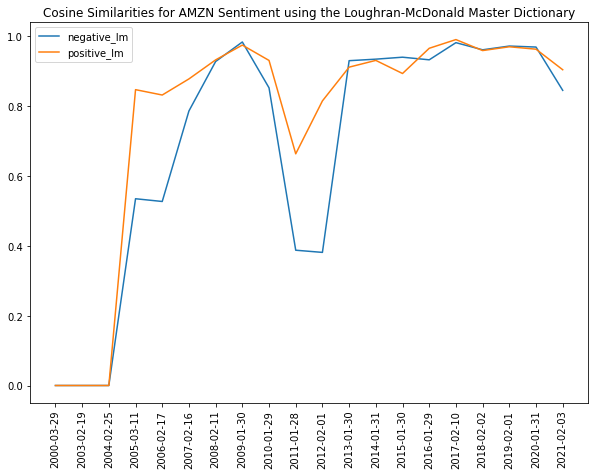

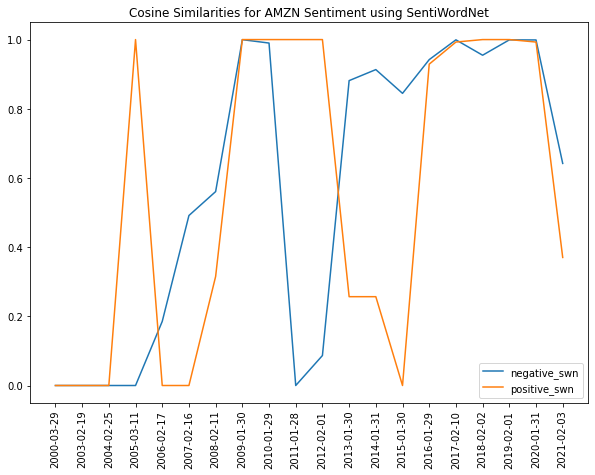

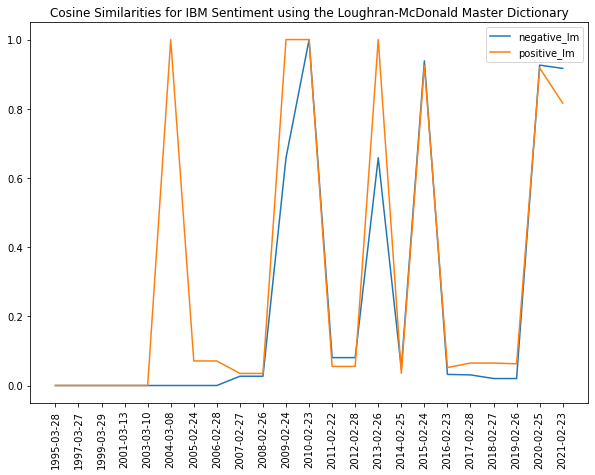

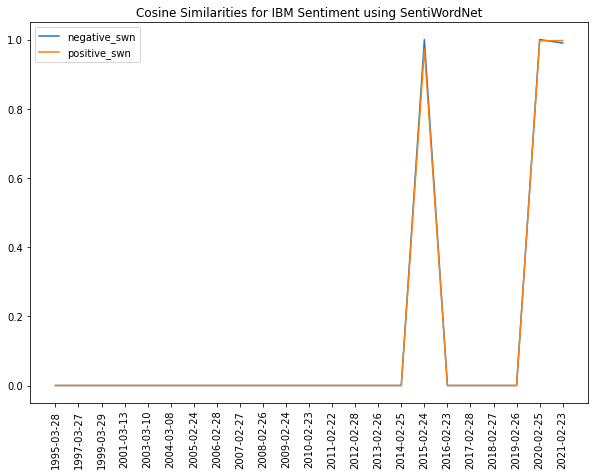

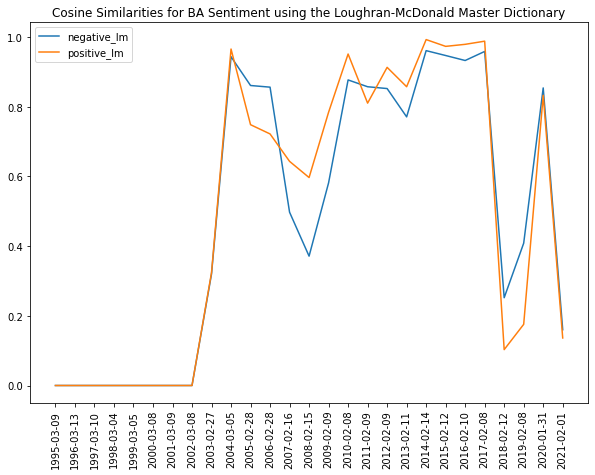

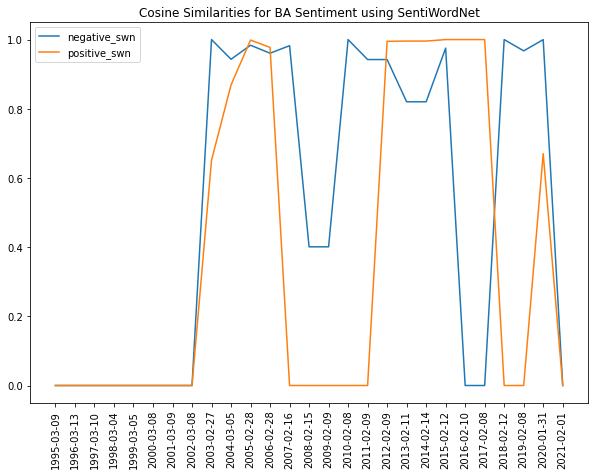

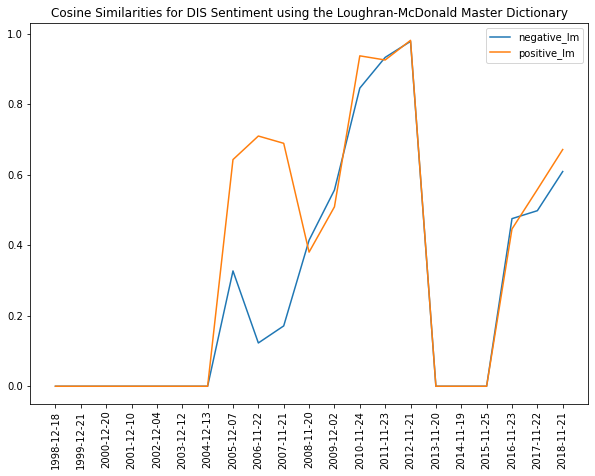

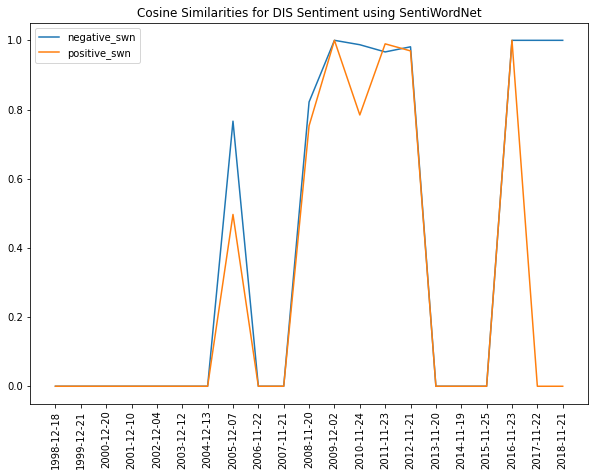

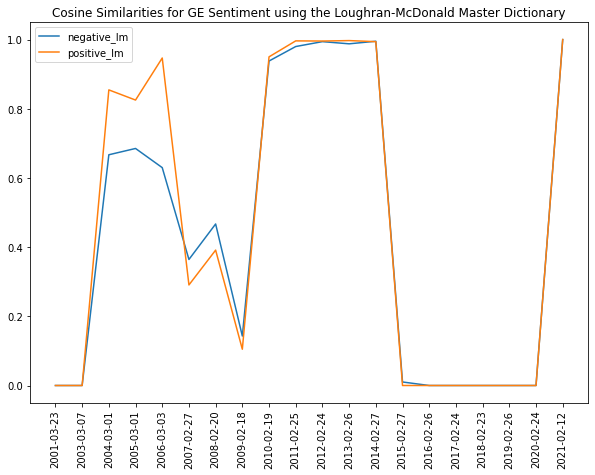

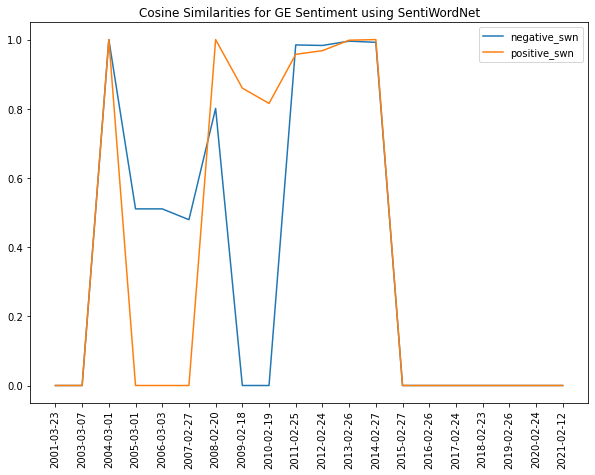

In [205]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement
    cosine_similarities = []    
    
    for i in range(len(tfidf_matrix)-1):
        cosine_similarities.append(cosine_similarity(tfidf_matrix[i].reshape(1, -1),tfidf_matrix[i+1].reshape(1, -1))[0,0])
    
    return cosine_similarities

file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

cosine_similarities_lm = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks_lm.items()}

cosine_similarities_swn = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks_swn.items()}



def plot_similarities(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(10, 7))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates, similarities, label=label)
        plt.legend()
        plt.xticks(rotation=90)

    plt.show()

def Reverse(lst):
    return [ele for ele in reversed(lst)]

for ticker in cik_lookup:
    file_dates[ticker] = Reverse(file_dates[ticker])
    cosine_similarities_lm[ticker]['negative_lm'] = Reverse(cosine_similarities_lm[ticker]['negative_lm'])
    cosine_similarities_lm[ticker]['positive_lm'] = Reverse(cosine_similarities_lm[ticker]['positive_lm'])
    cosine_similarities_swn[ticker]['negative_swn'] = Reverse(cosine_similarities_swn[ticker]['negative_swn'])
    cosine_similarities_swn[ticker]['positive_swn'] = Reverse(cosine_similarities_swn[ticker]['positive_swn'])
    


for ticker in cik_lookup:
    plot_similarities(
        [cosine_similarities_lm[ticker][sentiment] for sentiment in lm_senti_vocab],
        file_dates[ticker][1:],
        'Cosine Similarities for {} Sentiment using the Loughran-McDonald Master Dictionary'.format(ticker),
        lm_senti_vocab)

    plot_similarities(
        [cosine_similarities_swn[ticker][sentiment] for sentiment in swn_senti_vocab],
        file_dates[ticker][1:],
        'Cosine Similarities for {} Sentiment using SentiWordNet'.format(ticker),
        swn_senti_vocab)

In [206]:
def read_price_data(csv_path,dates,Ticker):
    historical_data = {}
    historical_df = pd.read_csv (csv_path)[['Date','Close']]
    historical_df['year'] = [None] * len(historical_df['Date'])
    years =[]
    prices = []
    for i in range(0,len(historical_df['Date'])):
        historical_df['year'][i]=historical_df['Date'][i][0:4]
    for i in range (0, len(dates)):
        dates[i] = dates[i][0:4]
    for i in range(0,len(historical_df["year"])):
        if historical_df["year"][i] not in historical_data:

            if historical_df["year"][i] in dates:
                years.append(historical_df["year"][i])
                prices.append(historical_df["Close"][i])
                historical_data[historical_df["year"][i]] = historical_df["Close"][i]
    
    plt.figure(1, figsize=(10, 7))
    plt.title(Ticker + " Price History")
    plt.plot(years, prices, label="price")
    plt.legend()
    plt.xticks(rotation=90)

    return historical_data

AMZN_10k_dates = file_dates['AMZN'][1:]
IBM_10k_dates = file_dates['IBM'][1:]
BA_10k_dates = file_dates['BA'][1:]
GE_10k_dates = file_dates['GE'][1:]
DIS_10k_dates = file_dates['DIS'][1:]

<ipython-input-206-eaf3b2dc44f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df['year'][i]=historical_df['Date'][i][0:4]


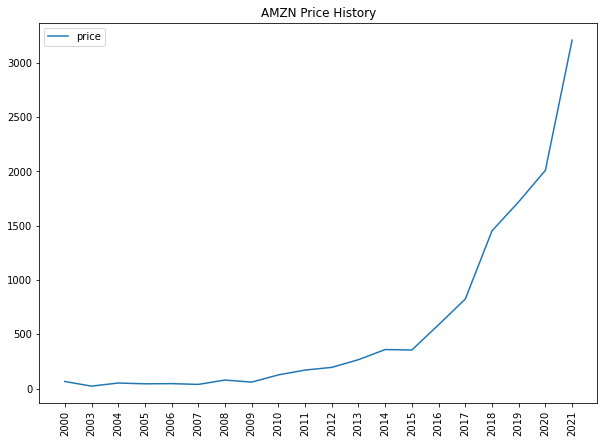

In [207]:
AMZN_historical = read_price_data('AMZN_historical.csv',AMZN_10k_dates,'AMZN')


<ipython-input-206-eaf3b2dc44f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df['year'][i]=historical_df['Date'][i][0:4]


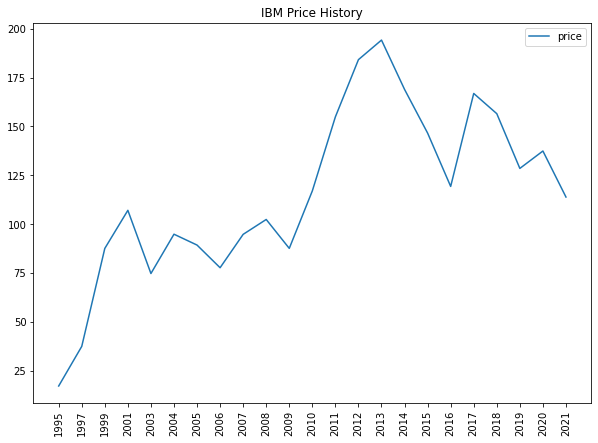

In [208]:
IBM_historical = read_price_data('IBM_historical.csv',IBM_10k_dates,'IBM')


<ipython-input-206-eaf3b2dc44f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df['year'][i]=historical_df['Date'][i][0:4]


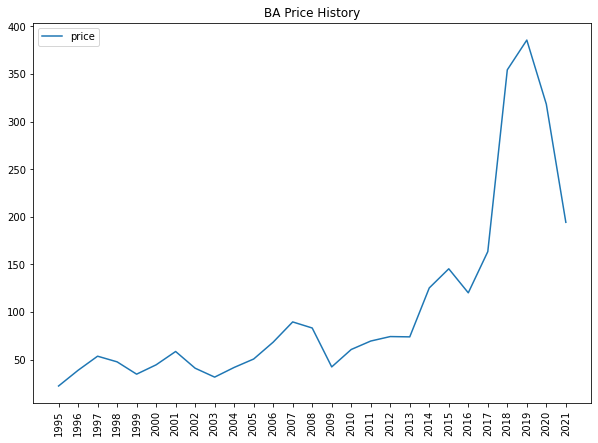

In [209]:
BA_historical = read_price_data('BA_historical.csv',BA_10k_dates,'BA')

<ipython-input-206-eaf3b2dc44f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df['year'][i]=historical_df['Date'][i][0:4]


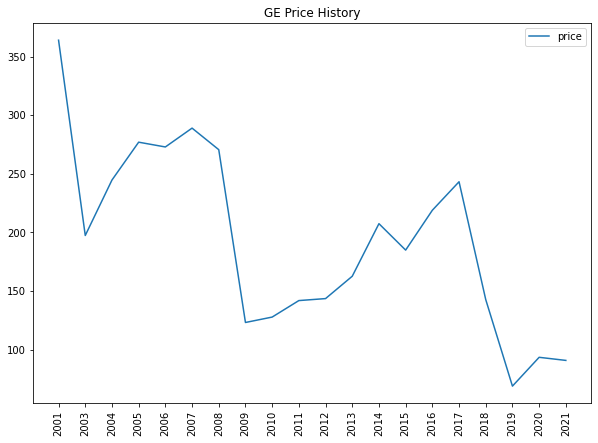

In [210]:
GE_historical = read_price_data('GE_historical.csv',GE_10k_dates,'GE')

<ipython-input-206-eaf3b2dc44f7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df['year'][i]=historical_df['Date'][i][0:4]


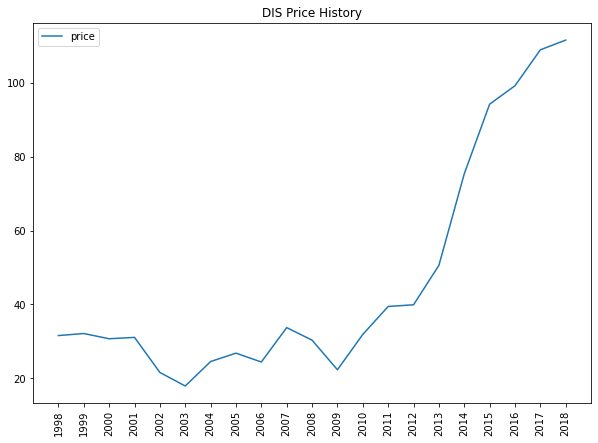

In [211]:
DIS_historical = read_price_data('DIS_historical.csv',DIS_10k_dates,'DIS')

In [220]:
from IPython.display import display
def getStockResults(ticker,historical):
    results_lm = pd.DataFrame(np.array([cosine_similarities_lm[ticker][sentiment] for sentiment in lm_senti_vocab]).transpose(),columns=lm_senti_vocab)
    results_swn = pd.DataFrame(np.array([cosine_similarities_swn[ticker][sentiment] for sentiment in swn_senti_vocab]).transpose(),columns=swn_senti_vocab)
    results = pd.concat([results_lm, results_swn], axis=1, join='inner')
    results['Date'] = file_dates[ticker][1:]
    for i in range (0, len(results['Date'])):
        results['Date'][i] = results['Date'][i][0:4]
    results['Price'] = ['0']*len(results['Date'])
    for i in range(0, len(results['Date'])):
        results['Price'][i]=historical[results['Date'][i]]
    results['lm_prediction'] = ['0']*len(results['Date'])
    results['swn_prediction'] = ['0']*len(results['Date'])
    results['actual'] = ['0']*len(results['Date'])
    for i in range(0, len(results['Date'])):
        if results['negative_lm'][i]<results['positive_lm'][i]:
            results['lm_prediction'][i] = 'BUY'
        else:
            results['lm_prediction'][i] = 'SELL'
        if results['negative_swn'][i]<results['positive_swn'][i]:
            results['swn_prediction'][i] = 'BUY'
        else:
            results['swn_prediction'][i] = 'SELL'
        if i != len(results['Date'])-1:
            if results['Price'][i]<results['Price'][i+1]:
                results['actual'][i] = 'BUY'
            else:
                results['actual'][i] = 'SELL'
        else:
            results['actual'][i] = 'TBD'
        
        
    return results
AMZN_results = getStockResults('AMZN',AMZN_historical)
BA_results = getStockResults('BA',BA_historical)
IBM_results = getStockResults('IBM',IBM_historical)
GE_results = getStockResults('GE',GE_historical)
DIS_results = getStockResults('DIS',DIS_historical)

display(AMZN_results)
display(BA_results)
display(IBM_results)
display(GE_results)
display(DIS_results)

AMZN_results.to_csv('AMZN_results.csv', index=False)
BA_results.to_csv('BA_results.csv', index=False)
IBM_results.to_csv('IBM_results.csv', index=False)
GE_results.to_csv('GE_results.csv', index=False)
DIS_results.to_csv('DIS_results.csv', index=False)


<ipython-input-220-0292b60a3999>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Date'][i] = results['Date'][i][0:4]
<ipython-input-220-0292b60a3999>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Price'][i]=historical[results['Date'][i]]
<ipython-input-220-0292b60a3999>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['lm_prediction'][i] = 'SELL'
<ipython-input-220-0292b60a3999>:23: SettingWithCopyWarnin

,negative_lm,positive_lm,negative_swn,positive_swn,Date,Price,lm_prediction,swn_prediction,actual
0,0.000000,0.000000,0.000000,0.000000,2000,64.5625,SELL,SELL,SELL
1,0.000000,0.000000,0.000000,0.000000,2003,21.85,SELL,SELL,BUY
2,0.000000,0.000000,0.000000,0.000000,2004,50.400002,SELL,SELL,SELL
3,0.534186,0.846214,0.000000,1.000000,2005,43.220001,BUY,BUY,BUY
4,0.526354,0.830865,0.185223,0.000000,2006,44.82,BUY,SELL,SELL
5,0.785260,0.876928,0.491387,0.000000,2007,37.669998,BUY,SELL,BUY
6,0.926715,0.931350,0.560540,0.315164,2008,77.699997,BUY,SELL,SELL
7,0.982558,0.973697,0.999730,1.000000,2009,58.82,SELL,BUY,BUY
8,0.851439,0.929774,0.989949,1.000000,2010,125.410004,BUY,BUY,BUY
9,0.386957,0.662676,0.000000,1.000000,2011,169.639999,BUY,BUY,BUY


,negative_lm,positive_lm,negative_swn,positive_swn,Date,Price,lm_prediction,swn_prediction,actual
0,0.000000,0.000000,0.000000,0.000000,1995,22.25,SELL,SELL,BUY
1,0.000000,0.000000,0.000000,0.000000,1996,38.75,SELL,SELL,BUY
2,0.000000,0.000000,0.000000,0.000000,1997,53.5625,SELL,SELL,SELL
3,0.000000,0.000000,0.000000,0.000000,1998,47.625,SELL,SELL,SELL
4,0.000000,0.000000,0.000000,0.000000,1999,34.6875,SELL,SELL,BUY
5,0.000000,0.000000,0.000000,0.000000,2000,44.5,SELL,SELL,BUY
6,0.000000,0.000000,0.000000,0.000000,2001,58.5,SELL,SELL,SELL
7,0.000000,0.000000,0.000000,0.000000,2002,40.950001,SELL,SELL,SELL
8,0.320073,0.324002,1.000000,0.651244,2003,31.59,BUY,SELL,BUY
9,0.943685,0.965714,0.943107,0.868861,2004,41.75,BUY,SELL,BUY


,negative_lm,positive_lm,negative_swn,positive_swn,Date,Price,lm_prediction,swn_prediction,actual
0,0.000000,0.000000,0.000000,0.000000,1995,17.238289,SELL,SELL,BUY
1,0.000000,0.000000,0.000000,0.000000,1997,37.494026,SELL,SELL,BUY
2,0.000000,0.000000,0.000000,0.000000,1999,87.595604,SELL,SELL,BUY
3,0.000000,0.000000,0.000000,0.000000,2001,107.07457,SELL,SELL,SELL
4,0.000000,0.000000,0.000000,0.000000,2003,74.760994,SELL,SELL,BUY
5,0.000000,1.000000,0.000000,0.000000,2004,94.866158,BUY,SELL,SELL
6,0.000000,0.070959,0.000000,0.000000,2005,89.311661,BUY,SELL,SELL
7,0.000000,0.070959,0.000000,0.000000,2006,77.724663,BUY,SELL,BUY
8,0.026748,0.034919,0.000000,0.000000,2007,94.789673,BUY,SELL,BUY
9,0.026748,0.034919,0.000000,0.000000,2008,102.39962,BUY,SELL,SELL


,negative_lm,positive_lm,negative_swn,positive_swn,Date,Price,lm_prediction,swn_prediction,actual
0,0.000000,0.000000,0.000000,0.000000,2001,363.942322,SELL,SELL,SELL
1,0.000000,0.000000,0.000000,0.000000,2003,197.307693,SELL,SELL,BUY
2,0.667003,0.854567,1.000000,1.000000,2004,244.615387,BUY,SELL,BUY
3,0.685233,0.825172,0.510584,0.000000,2005,276.923065,BUY,SELL,SELL
4,0.629826,0.946733,0.510584,0.000000,2006,272.846161,BUY,SELL,BUY
5,0.364361,0.290695,0.479330,0.000000,2007,288.923065,SELL,SELL,SELL
6,0.466941,0.391344,0.801119,1.000000,2008,270.538452,SELL,BUY,SELL
7,0.142993,0.104872,0.000000,0.859745,2009,123.07692,SELL,BUY,BUY
8,0.938026,0.950065,0.000000,0.815435,2010,127.692307,BUY,BUY,BUY
9,0.979901,0.996238,0.984480,0.957344,2011,141.769226,BUY,SELL,BUY


,negative_lm,positive_lm,negative_swn,positive_swn,Date,Price,lm_prediction,swn_prediction,actual
0,0.000000,0.000000,0.000000,0.000000,1998,31.568001,SELL,SELL,BUY
1,0.000000,0.000000,0.000000,0.000000,1999,32.122906,SELL,SELL,SELL
2,0.000000,0.000000,0.000000,0.000000,2000,30.704813,SELL,SELL,BUY
3,0.000000,0.000000,0.000000,0.000000,2001,31.074751,SELL,SELL,SELL
4,0.000000,0.000000,0.000000,0.000000,2002,21.574755,SELL,SELL,SELL
5,0.000000,0.000000,0.000000,0.000000,2003,17.904976,SELL,SELL,BUY
6,0.000000,0.000000,0.000000,0.000000,2004,24.534254,SELL,SELL,BUY
7,0.327077,0.642831,0.766316,0.496621,2005,26.803205,BUY,SELL,SELL
8,0.122772,0.709652,0.000000,0.000000,2006,24.40601,BUY,SELL,BUY
9,0.171163,0.688965,0.000000,0.000000,2007,33.728436,BUY,SELL,SELL


In [221]:
def getAccuracy(results,ticker):
    lm_correct = 0
    lm_total = 0
    swn_correct = 0
    swn_total = 0
    for i in range(0,len(results['Price'])):
        if results['negative_lm'][i] != 0 or results['positive_lm'][i] != 0:
            if results['actual'][i]==results['lm_prediction'][i]:
                lm_correct += 1
            lm_total+=1
        if results['negative_swn'][i] != 0 or results['positive_swn'][i] != 0:
            if results['actual'][i]==results['swn_prediction'][i]:
                swn_correct += 1
            swn_total+=1
        
    lm_accuracy = lm_correct*100.00/lm_total
    swn_accuracy = swn_correct*100.00/swn_total
    print("Accuracy for evaluating 10K documents for "+ticker)
    print("The signals using the algorithm that used the Loughran-McDonald Master Dictionary had an accuracy of: "+ str(lm_accuracy)+"%")
    print("The signals using the algorithm that used the SentiWordNet had an accuracy of: "+ str(swn_accuracy)+"%")
    print()
    #return lm_accuracy,swn_accuracy

getAccuracy(AMZN_results,'AMZN')
getAccuracy(IBM_results,'IBM')
getAccuracy(BA_results,'BA')
getAccuracy(GE_results,'GE')
getAccuracy(DIS_results,'DIS')
        

Accuracy for evaluating 10K documents for AMZN
The signals using the algorithm that used the Loughran-McDonald Master Dictionary had an accuracy of: 47.05882352941177%
The signals using the algorithm that used the SentiWordNet had an accuracy of: 58.8235294117647%

Accuracy for evaluating 10K documents for IBM
The signals using the algorithm that used the Loughran-McDonald Master Dictionary had an accuracy of: 44.44444444444444%
The signals using the algorithm that used the SentiWordNet had an accuracy of: 66.66666666666667%

Accuracy for evaluating 10K documents for BA
The signals using the algorithm that used the Loughran-McDonald Master Dictionary had an accuracy of: 52.63157894736842%
The signals using the algorithm that used the SentiWordNet had an accuracy of: 55.55555555555556%

Accuracy for evaluating 10K documents for GE
The signals using the algorithm that used the Loughran-McDonald Master Dictionary had an accuracy of: 69.23076923076923%
The signals using the algorithm that 